### In this notebook, we try to predict the rain fall using a neural network model.

# **Setup**

Mount GGdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Go to the project directory in my GGDrive

In [2]:
cd "/content/drive/MyDrive/Colab Notebooks/Rain Prediction"

/content/drive/MyDrive/Colab Notebooks/Rain Prediction


Prepare some constants

In [3]:
DATA_PATH = "."
MODEL_PATH = "model"

# **Prepare Data**


The dataset contain **temperature**, **humidity**, **rain fall** each day from 1979 to 2012

In [4]:
import numpy as np
import pandas as pd
from os import path

data_frame = pd.read_csv("DN_RF_Data.csv")
data_frame = data_frame.drop(columns=["TIME"])

data_frame["TIME"] = data_frame.apply(lambda row: row.name % 365, axis=1) # apply this function to each row

data_frame.tail(100)

,TEMP,HUMD,RAIN_FALL,TIME
12319,28.5,82,0.0,274
12320,28.8,80,0.0,275
12321,28.8,77,0.0,276
12322,26.8,90,72.4,277
12323,27.6,85,75.4,278
...,...,...,...,...
12414,24.1,89,3.4,4
12415,24.4,89,0.0,5
12416,25.8,87,2.0,6
12417,22.0,86,11.8,7


### **Show data**

Use `matplotlib` to visualize data.



In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["figure.figsize"] = (18, 8)
mpl.rcParams["axes.grid"] = False

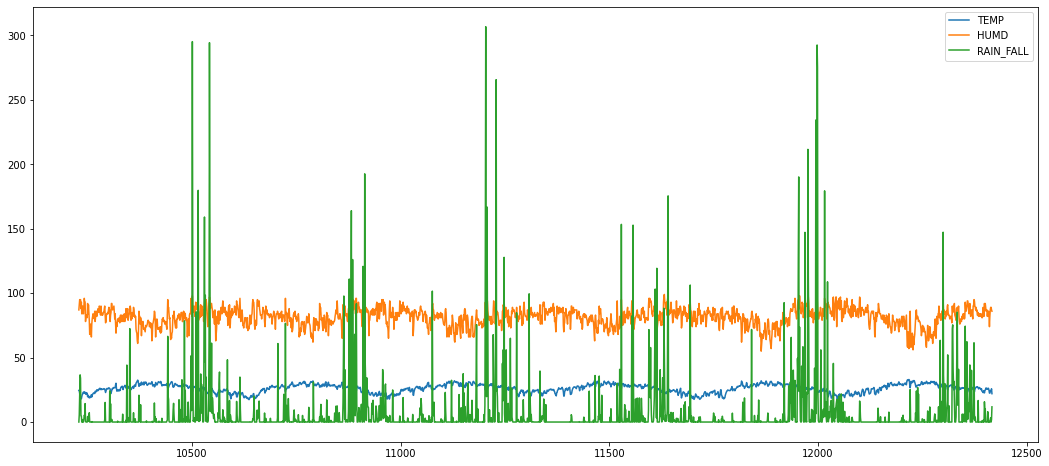

In [8]:
plot_cols = ["TEMP", "HUMD", "RAIN_FALL"];

values = data_frame[plot_cols][-365 * 6  : -1]

values.plot()

In each frequency, temperature, humidity and rain fall is almost repeat the same year by year.

Next, we check the information about the dataset such as: count null rows, get the dataset's shape, analyze dataset, ...

In [ ]:
data_frame.isnull().sum()

TEMP         0
HUMD         0
RAIN_FALL    0
TIME         0
dtype: int64

In [ ]:
print(data_frame.shape)

(12419, 4)


In [ ]:
data_frame.describe()

,TEMP,HUMD,RAIN_FALL,TIME
count,12419.000000,12419.000000,12419.000000,12419.000000
mean,25.813415,82.267332,6.295040,181.871004
std,3.180205,6.563284,22.502588,105.440975
min,13.900000,47.000000,0.000000,0.000000
25%,23.500000,79.000000,0.000000,91.000000
50%,26.300000,83.000000,0.000000,182.000000
75%,28.300000,87.000000,1.800000,273.000000
max,33.500000,99.000000,529.600000,364.000000


In [ ]:
data_frame.cov()

,TEMP,HUMD,RAIN_FALL,TIME
TEMP,10.113706,-9.885540,-5.874357,66.841165
HUMD,-9.885540,43.076700,49.051737,6.177103
RAIN_FALL,-5.874357,49.051737,506.366445,496.413453
TIME,66.841165,6.177103,496.413453,11117.799110


### **Preprocess Data**

The input data have **5 day previous information** (include the current day) in one row.

In [ ]:
NUM_ROW = data_frame.shape[0]
DATE_OFFSET_PREVIOUS = 5
DATE_OFFSET_MAX = 10

In [ ]:
offset_data = pd.DataFrame(data_frame[DATE_OFFSET_MAX : NUM_ROW - DATE_OFFSET_MAX], copy=True).reset_index(drop=True)

X_temp = pd.DataFrame()
X_temp["CURRENT"] = offset_data["TEMP"]

X_humd = pd.DataFrame()
X_humd["CURRENT"] = offset_data["HUMD"]

for offset in range(1, DATE_OFFSET_PREVIOUS):
  offset_data = pd.DataFrame(data_frame[DATE_OFFSET_MAX - offset : NUM_ROW - (DATE_OFFSET_MAX + offset)], copy=True).reset_index(drop=True)

  X_temp[f"{offset}DAYS_PRE"] = offset_data["TEMP"]
  X_humd[f"{offset}DAYS_PRE"] = offset_data["HUMD"]

print(X_temp.shape)
print(X_humd.shape)

(12399, 5)
(12399, 5)


In [ ]:
offset_data = pd.DataFrame(data_frame[DATE_OFFSET_MAX : NUM_ROW - DATE_OFFSET_MAX], copy=True).reset_index(drop=True)

X_rain_fall = pd.DataFrame()
X_rain_fall["CURRENT"] = offset_data["RAIN_FALL"]

for offset in range(1, DATE_OFFSET_PREVIOUS):
  offset_data = pd.DataFrame(data_frame[DATE_OFFSET_MAX - offset : NUM_ROW - (DATE_OFFSET_MAX + offset)], copy=True).reset_index(drop=True)

  X_rain_fall[f"{offset}DAYS_PRE"] = offset_data["RAIN_FALL"]

print(X_rain_fall.shape)

(12399, 5)


The label data is **the average rain fall in 5 next day**.

In [ ]:
def avg_rain_fall_5day_next(row, df_rain):
  if row.name > df_rain.size - 1 - 5:
    return row
  else:
    return np.average(df_rain[row.name + 1 : row.name + 5])

rain_fall_df = data_frame.get(["RAIN_FALL"])
Y = pd.DataFrame()
Y["RAIN_FALL_5DAYS_NEXT"] = rain_fall_df.apply(lambda x: avg_rain_fall_5day_next(x, rain_fall_df["RAIN_FALL"]), axis=1)

Y = pd.DataFrame(Y[DATE_OFFSET_MAX : NUM_ROW - DATE_OFFSET_MAX], columns=Y.columns).reset_index(drop=True)

Y.shape

(12399, 1)

In [ ]:
X_time = data_frame.get(["TIME"])[DATE_OFFSET_MAX : NUM_ROW - DATE_OFFSET_MAX].reset_index(drop=True)
print(X_time.shape)

(12399, 1)


We using `MinMaxScaller` from `sklearn` library to normalize data in range 0 to 100.

In [ ]:
SCALLER_MAX = 100
SCALLER_MIN = 0

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_X_humd = MinMaxScaler(feature_range=(SCALLER_MIN, SCALLER_MAX))
X_humd = pd.DataFrame(scaler_X_humd.fit_transform(X_humd), columns=X_humd.columns)

scaler_X_temp = MinMaxScaler(feature_range=(SCALLER_MIN, SCALLER_MAX))
X_temp = pd.DataFrame(scaler_X_temp.fit_transform(X_temp), columns=X_temp.columns)

scaler_X_rain_fall = MinMaxScaler(feature_range=(SCALLER_MIN, SCALLER_MAX))
X_rain_fall = pd.DataFrame(scaler_X_rain_fall.fit_transform(X_rain_fall), columns=X_rain_fall.columns)

scaler_X_time = MinMaxScaler(feature_range=(SCALLER_MIN, SCALLER_MAX))
X_time = pd.DataFrame(scaler_X_time.fit_transform(X_time), columns=X_time.columns)

scaler_Y = MinMaxScaler(feature_range=(SCALLER_MIN, SCALLER_MAX))
Y = pd.DataFrame(scaler_Y.fit_transform(Y), columns=Y.columns)

Join `temp` and `humd` to 1 Input tensor

In [ ]:
temp = np.reshape(X_temp.values, (X_temp.shape[0], X_temp.shape[1], 1))
humd = np.reshape(X_humd.values, (X_humd.shape[0], X_humd.shape[1], 1))
X_temp_humd = np.concatenate((temp, humd), axis=2)
X_temp_humd.shape

Put `rain_fall` data in 2D tensor

In [ ]:
X_rain_fall = np.reshape(X_rain_fall.values, (X_rain_fall.shape[0], X_rain_fall.shape[1], 1))
X_rain_fall.shape

(12399, 5, 1)

### **Split data**

We split the data into train and test dataset. The train dataset contain 80% the original data and the test data is the remaining.

In [ ]:
TRAIN_LENGTH = int(X_time.shape[0] * 0.8)
VAL_LENGTH = X_time.shape[0] - TRAIN_LENGTH

X_temp_humd_train = X_temp_humd[VAL_LENGTH : ] # (None, 5, 2)
X_temp_humd_val = X_temp_humd[0 : VAL_LENGTH]
X_rain_fall_train = X_rain_fall[VAL_LENGTH : ] # (None, 2, )
X_rain_fall_val = X_rain_fall[0 : VAL_LENGTH]
X_time_train = X_time[VAL_LENGTH : ] # (None, 1, )
X_time_val = X_time[0 : VAL_LENGTH]

Y_train = Y[VAL_LENGTH : ]
Y_val = Y[0 : VAL_LENGTH]

# **Build Model**

The Rain Fall Model have **3 small model** below.

We using Recurrent Neural Network to build this model.

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Bidirectional, LSTM, InputLayer, Dropout, Conv1D

**The first small model** accept `temperature` and `humidity` in **5 day previous** as the input. 

We made **1 Convolutional Layer** to get the relation between the information of the nearly day. 

Then the input is flowing throwing **RNN layers** such as **Bidirectional** and **LSTM** to store the history of the weather. 

After that, we put the **Fully Connected** in the rest to make prediction. 

In [ ]:
temp_humd_model = Sequential(
  InputLayer(input_shape=(5, 2))    
)

temp_humd_model.add(Conv1D(32, kernel_size=3))
temp_humd_model.add(Bidirectional(LSTM(64, return_sequences=True)))
temp_humd_model.add(LSTM(32))
temp_humd_model.add(Dropout(0.2))
temp_humd_model.add(Dense(32, activation="relu"))
temp_humd_model.add(BatchNormalization())
temp_humd_model.add(Dense(4, activation="relu"))

temp_humd_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 3, 32)             224       
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 3, 128)            49664     
_________________________________________________________________
lstm_27 (LSTM)               (None, 32)                20608     
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_16 (Batc (None, 32)                128       
_________________________________________________________________
dense_28 (Dense)             (None, 4)               

**The second model** have the input with shape (5, 1) is the rainfall in 5 days previous.

It is **the same with the first small model**. This model also has **RNN layers** and **Fully Connected Layers**.

But the result is more layer than the fist small layer because **the rain fall informaion in the past is more importaint** to predict rain fall in the future.

In [ ]:
rain_fall_model = Sequential(
    InputLayer(input_shape=(5, 1))
)

rain_fall_model.add(Conv1D(32, kernel_size=3))
rain_fall_model.add(Bidirectional(LSTM(128, return_sequences=True)))
rain_fall_model.add(LSTM(32, return_sequences=True))
rain_fall_model.add(Dropout(0.2))
rain_fall_model.add(LSTM(16))
rain_fall_model.add(Dense(32, activation="relu"))
rain_fall_model.add(BatchNormalization())
rain_fall_model.add(Dense(7, activation="relu"))

rain_fall_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 3, 32)             128       
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 3, 256)            164864    
_________________________________________________________________
lstm_29 (LSTM)               (None, 3, 32)             36992     
_________________________________________________________________
dropout_12 (Dropout)         (None, 3, 32)             0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 16)                3136      
_________________________________________________________________
dense_29 (Dense)             (None, 32)                544       
_________________________________________________________________
batch_normalization_17 (Batc (None, 32)              

**The third small model** is the date of year (in range 0 - 364).

Because rain fall is **depended on season of the year** so the time is super important. But it **doesn't have the same properties** with rain fall, temperature, humidity. So We put it in that small layer.

In [ ]:
time_model = Sequential(
    InputLayer(input_shape=(1, ))
)

time_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


We combine all 3 models above to **one main model**.

This model contain the normal **Fully Connected Layers** to predict the average rain fall in next 5 days.

In [ ]:
from tensorflow.keras.layers import Concatenate

concated_layer = Concatenate()([temp_humd_model.output, rain_fall_model.output, time_model.output])
x = (Dense(64, activation="relu"))(concated_layer)
x = (BatchNormalization())(x)
x = (Dense(128, activation="relu"))(x)
x = (BatchNormalization())(x)
x = (Dense(512, activation="relu"))(x)
x = (BatchNormalization())(x)
x = (Dropout(0.2))(x)
x = (Dense(128, activation="relu"))(x)
x = (BatchNormalization())(x)
x = (Dense(64, activation="relu"))(x)
x = (BatchNormalization())(x)
x = (Dense(32, activation="relu"))(x)
x = (BatchNormalization())(x)
x = (Dense(1, activation="relu"))(x)

model = Model(inputs=[temp_humd_model.input, rain_fall_model.input, time_model.input], outputs=x, name="Concated_layer")

model.summary()

Model: "Concated_layer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 5, 1)]       0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 5, 2)]       0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 3, 32)        128         input_13[0][0]                   
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 3, 32)        224         input_12[0][0]                   
_____________________________________________________________________________________

Here is the models structure.

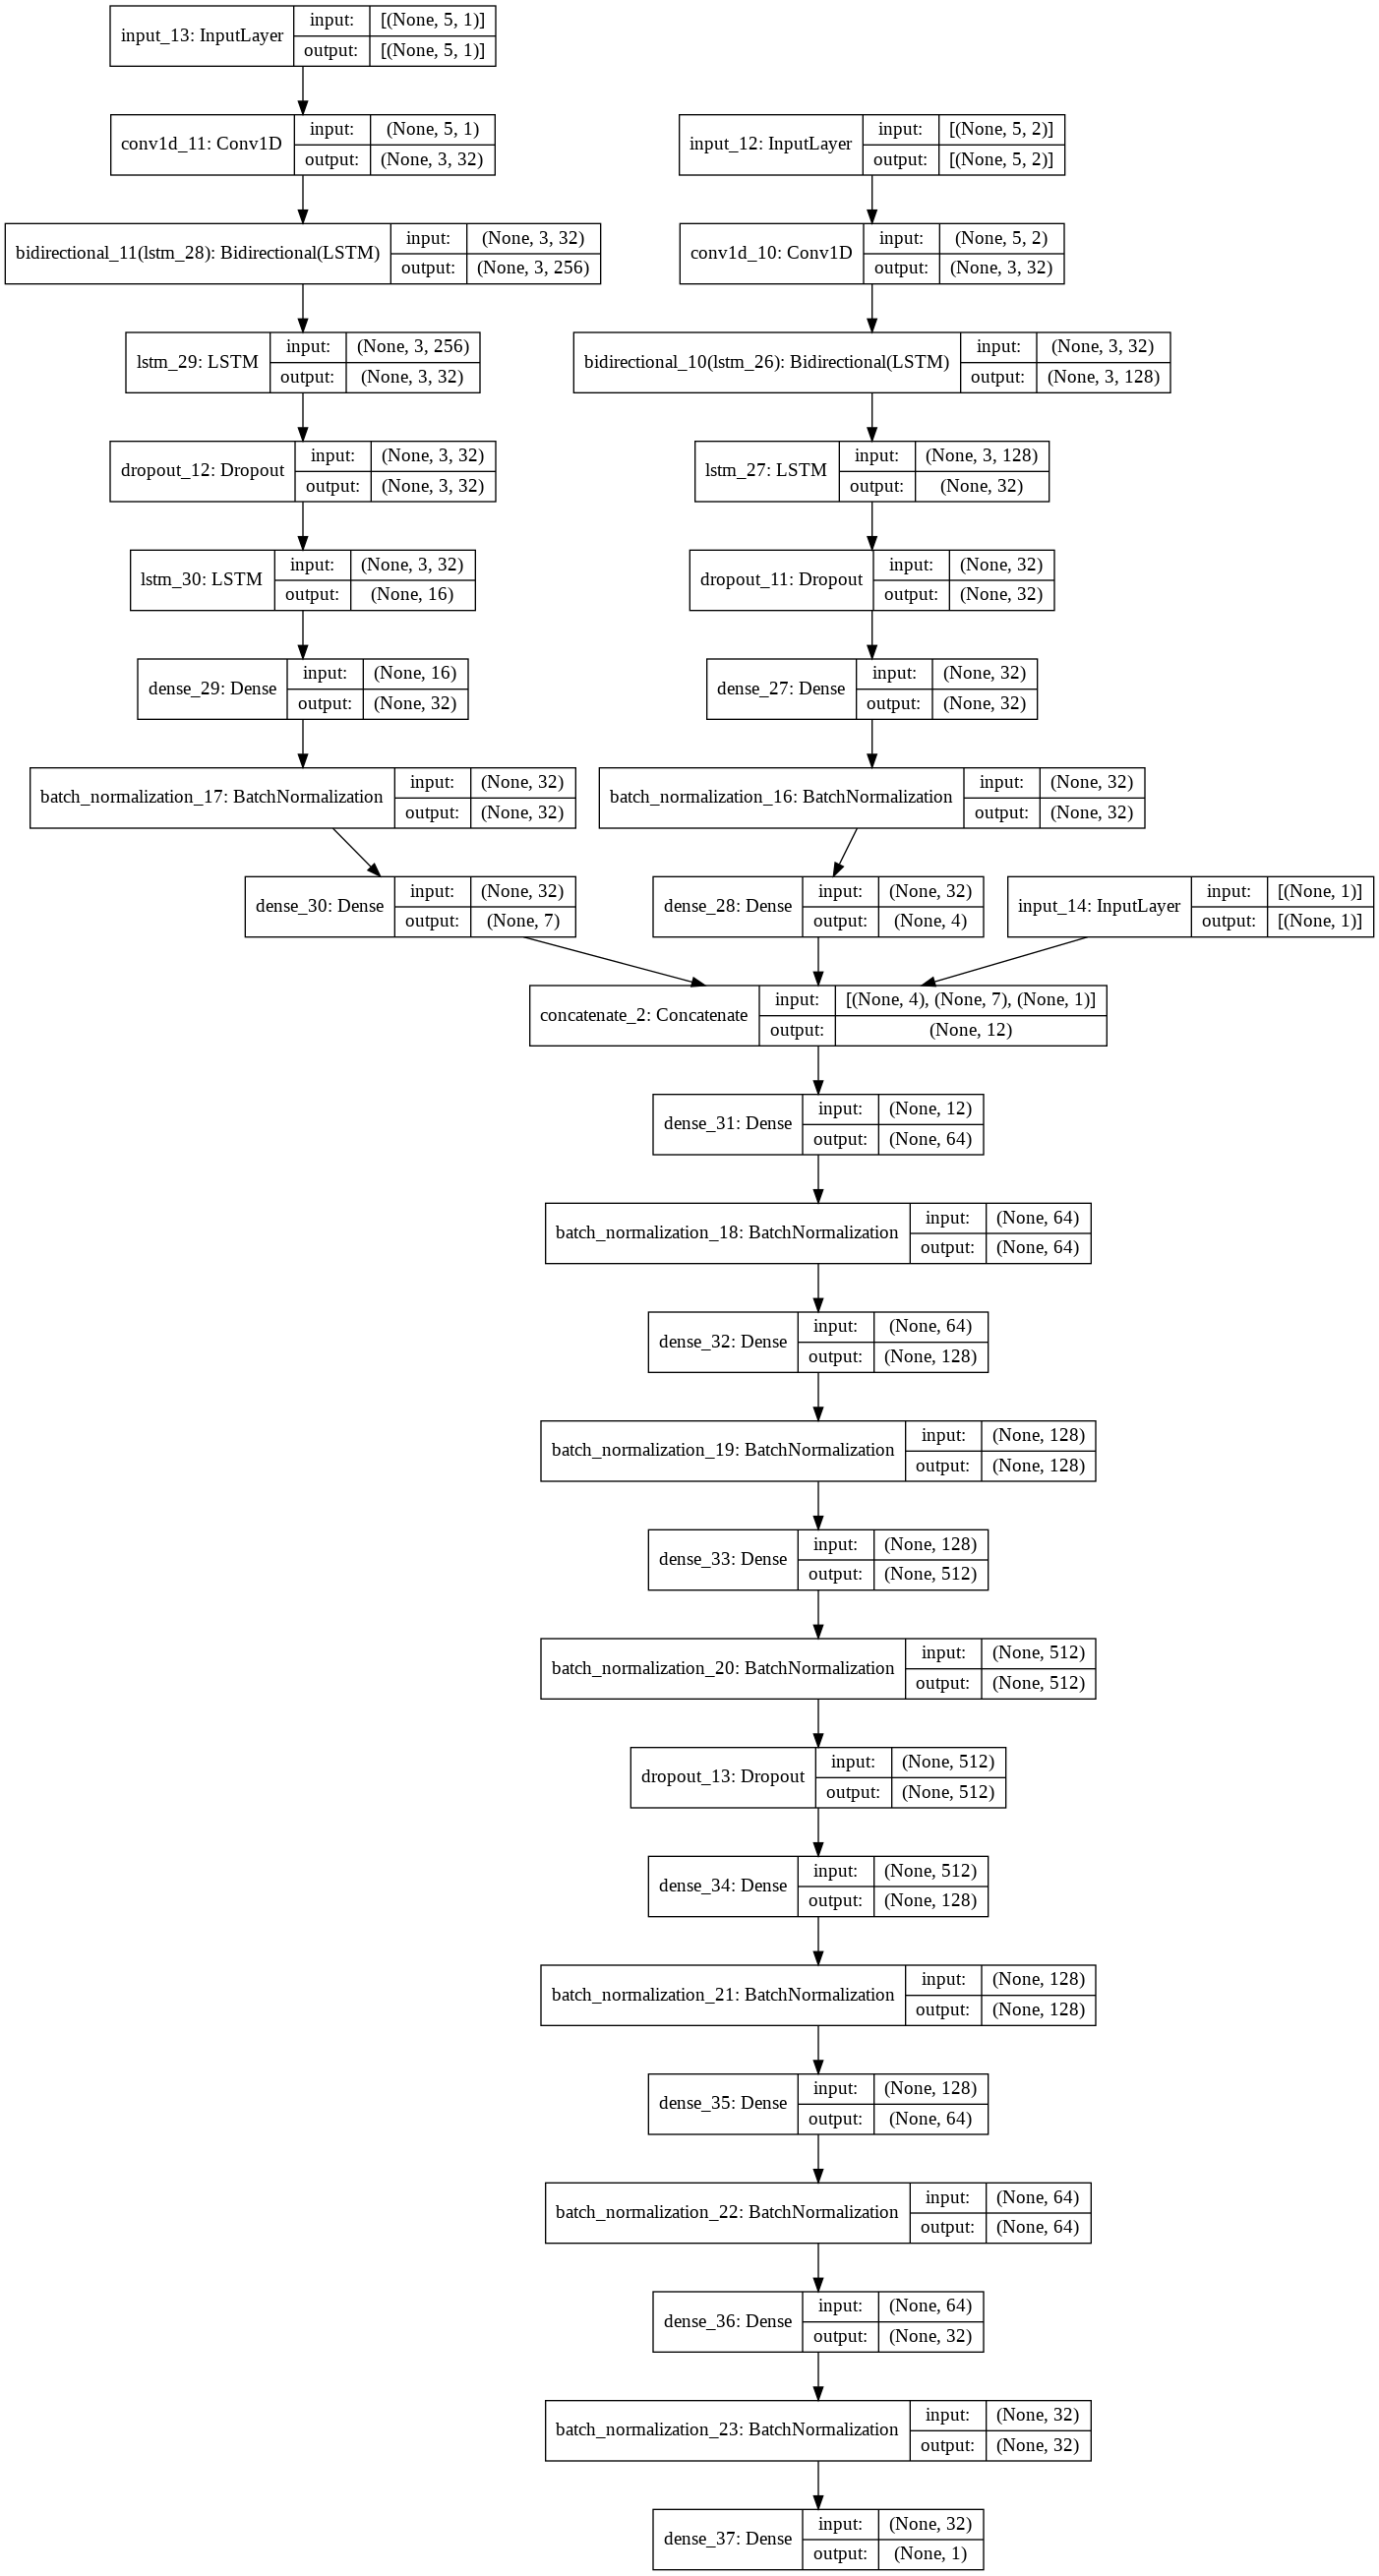

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
print(model.input_shape)
print(model.output_shape)

[(None, 5, 2), (None, 5, 1), (None, 1)]
(None, 1)


We compile the model with the **Adam optimizer function** and using **MSE loss function** to compute the accuracy.

In [ ]:
model.compile(optimizer="adam", loss="mse", metrics=["mse"])

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
from datetime import datetime

LOG_DIR = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=LOG_DIR, histogram_freq=1)

# **Train model**

In each training circle, we split the data into many batchs. **Each batch contain 64 samples**.

The model is training in **300 epochs**

In [ ]:
BATCH_SIZE = 64
EPOCHS = 300

We train save the training result into `history` variable.

In [ ]:
history = model.fit(
    x=[X_temp_humd_train, X_rain_fall_train, X_time_train], 
    y=Y_train, 
    validation_data=([X_temp_humd_val, X_rain_fall_val, X_time_val], Y_val), 
    batch_size=BATCH_SIZE, 
    callbacks=tensorboard_callback, 
    epochs=EPOCHS, 
    verbose=1
)

Epoch 1/300
155/155 [==============================] - 19s 55ms/step - loss: 44.0638 - mse: 44.0638 - val_loss: 51.0123 - val_mse: 51.0123
Epoch 2/300
155/155 [==============================] - 5s 33ms/step - loss: 42.4369 - mse: 42.4369 - val_loss: 37.5391 - val_mse: 37.5391
Epoch 3/300
155/155 [==============================] - 5s 32ms/step - loss: 41.6327 - mse: 41.6327 - val_loss: 39.8979 - val_mse: 39.8979
Epoch 4/300
155/155 [==============================] - 5s 32ms/step - loss: 41.1937 - mse: 41.1937 - val_loss: 35.7901 - val_mse: 35.7901
Epoch 5/300
155/155 [==============================] - 5s 33ms/step - loss: 40.8149 - mse: 40.8149 - val_loss: 37.3541 - val_mse: 37.3541
Epoch 6/300
155/155 [==============================] - 5s 32ms/step - loss: 41.0600 - mse: 41.0600 - val_loss: 37.7486 - val_mse: 37.7486
Epoch 7/300
155/155 [==============================] - 5s 32ms/step - loss: 40.9350 - mse: 40.9350 - val_loss: 36.4008 - val_mse: 36.4008
Epoch 8/300
155/155 [============

We visualize the training and the validation step below.

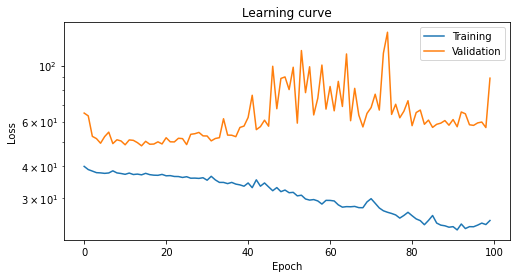

In [ ]:
h = history.model.history

# Plot training & validation loss value
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(h.history['loss'], label='loss')
ax.plot(h.history['val_loss'], label='val_loss')
plt.title('Learning curve')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
plt.legend(['Training', 'Validation'])
ax.set_yscale('log')

Because the rainfall is depended on many another things such as wind direction, sea level, pressure but we can't find enough data to train this model efficiently.

### **Save model**

Save model into drive

In [ ]:
model.save(filepath=MODEL_PATH)

### **Load model**

Load the saved model to start using it.

In [ ]:
from tensorflow.keras.models import load_model

model = load_model(MODEL_PATH)

## **Test Model**

We test the model in the test dataset we have prepare before.

The result is shown below.

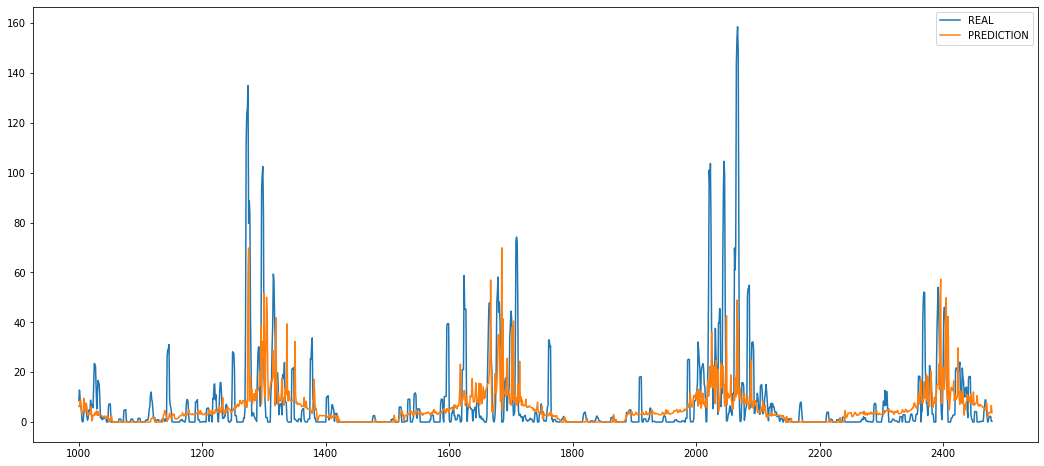

In [ ]:
test_df = pd.DataFrame()
test_df["REAL"] = np.reshape(scaler_Y.inverse_transform(Y_val), -1)

prediction = model.predict([X_temp_humd_val, X_rain_fall_val, X_time_val])
test_df["PREDICTION"] = np.reshape(scaler_Y.inverse_transform(prediction), -1)

test_df[1000 : 3000].plot()

# **Convert to tflite**

To use this model in edge devices such as android devices. We have to convert the model into `tensorflow lite` format.

In [ ]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_PATH) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('rain_prediction_model.tflite', 'wb') as f:
  f.write(tflite_model)